<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Final_Project/Deep_Learning_Final_Project_Artist_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artist Recognition
## 1. Imports and Drive Management

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import re
import pickle

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  

from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks.experimental import BackupAndRestore

2.4.1


In [2]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


#!ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [3]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## 2. Load data

  2,324,009,163 100%   28.86MB/s    0:01:16 (xfr#1, to-chk=0/1)
Extracting dataset in local environment...
Removing zip to save space...


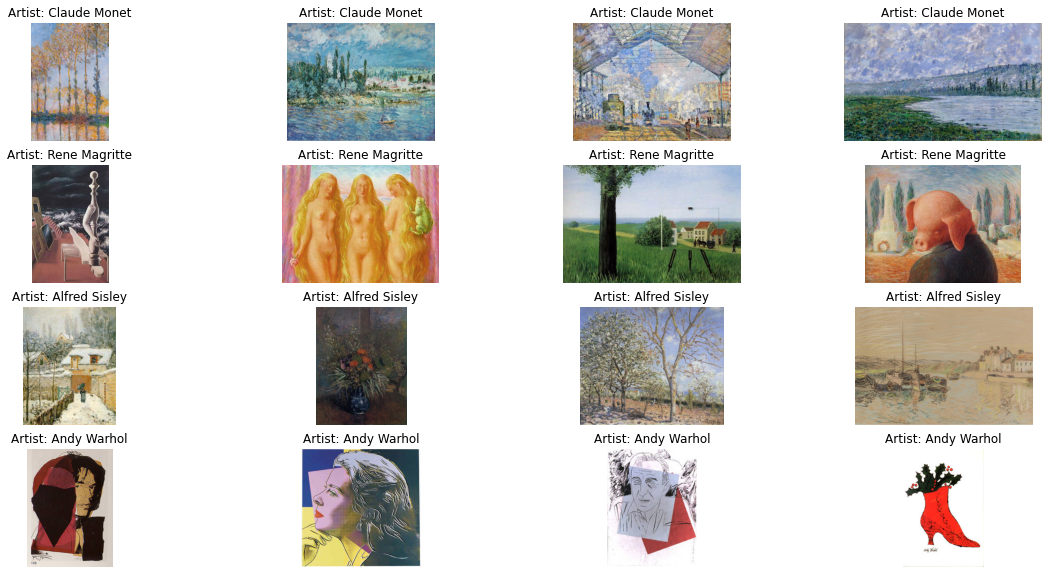

In [5]:
# resized/firstname_lastname_#.jpg
# images/firstname_lastname/firstname_lastname_#.jpg
import random

# path to google drive zip
path_to_zip = '/content/gdrive/My Drive/Colab Notebooks/DL2021/artists_recognition_dataset.zip'
# local path to data zip
local_path_to_folder = '/content/artists_recognition_dataset'

# download zip if it does not yet exist in local environment
if not Path(local_path_to_folder.replace(".zip", "")).exists():
  print("Downloading dataset to local environment...")
  !rsync --info=progress2 "{path_to_zip}" .
  print("Extracting dataset in local environment...")
  !unzip -q artists_recognition_dataset.zip | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'
  print("Removing zip to save space...")
  !rm artists_recognition_dataset.zip
else:
  print("Dataset already present in local environment")


# path to folder with images
path = '/content/artists_recognition_dataset/resized/resized'
images_dir = Path(path)

### PARSE DATASET ###

# key = path_to_image:Path
# value = artist:str
painting_artist_dict = {}

# key = artist:str
# value = path_to_image:Path
artist_painting_dict = {}

for image in images_dir.rglob("*"):
  if image.is_file() and str(image).endswith("jpg"):
        # Extract label from filename
        pattern= re.compile(r"(.*)_(\d*).jpg$")
        match = pattern.match(str(image.name))
        artist = match.group(1)
        instance = match.group(2)

        painting_artist_dict[str(image)] = artist
        if artist not in list(artist_painting_dict.keys()):
          artist_painting_dict[artist] = []
        artist_painting_dict[artist].append(image)
    
# print examples
def show_random_paintings(n_artists = 4, n_paintings = 4):
  
    fig, axes = plt.subplots(n_artists, n_paintings, figsize=(20,10))

    for r in range(n_artists):
        random_artist = random.choice(list(artist_painting_dict.keys()))
        random_images = random.sample(artist_painting_dict[random_artist], n_paintings)

        c=0
        for random_image_file in random_images:

          image = plt.imread(random_image_file)

          axes[r, c].imshow(image)
          axes[r, c].set_title("Artist: " + random_artist.replace('_', ' '))
          axes[r, c].axis('off')

          c+=1

    return plt.show()

show_random_paintings()

In [6]:
classes = list(artist_painting_dict.keys())
n_classes = len(classes)
assert n_classes == 50, "Number of classes (%d) should be 50, check Albrecht_Durer images" % n_classes

In [ ]:
# PARAM
train_input_shape = (128, 128, 3)
batch_size = 128
lr = 0.001
n_epoch = 60
early_stopping_patience = 10 # 0 = no early stopping

def initial_model():  

  model = Sequential() 


  model.add(Conv2D(128, kernel_size=(5, 5), padding='same', input_shape=train_input_shape))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 


  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 


  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 

  model.add(GlobalMaxPooling2D()) 
  model.add(Flatten())  
  model.add(Dense(n_classes))  
  model.add(Activation('softmax'))  


  opt = tf.keras.optimizers.Adam(learning_rate=lr)  

  model.compile(loss='categorical_crossentropy',  
  optimizer=opt,  
  metrics=['accuracy'])  

  return model 


In [ ]:
def plot_class_distribution(df, attribute):
    # inspect data
    print("Inspecting class: "+attribute)
    print("Number of classes: " + str(df[attribute].nunique()))
    
    
    # Retrieve max and min values
    unique, counts = np.unique(df[attribute], return_counts=True)
    maxFrequency = max(counts)
    maxLabel = unique[np.where(counts == maxFrequency)]
    minFrequency = min(counts)
    minLabel = unique[np.where(counts == minFrequency)]
    
    # Print max and min values
    print("Max value: " + str(maxLabel) + "; " + str(maxFrequency))
    print("Min value: " + str(minLabel) + "; " +str(minFrequency))
    
    
    # Plot Class Distribution
    fig, ax = plt.subplots(figsize=(14,10))
    ax.bar(unique, counts)
    
    
    # Beautify plot
    plt.title('Class Distribution: '+ attribute)
    plt.xticks(rotation='vertical')
    plt.xlabel(attribute)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

TRAIN_VALIDATE SPLIT
Train_validate samples: 6756
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 701
Min value: ['Jackson_Pollock']; 19


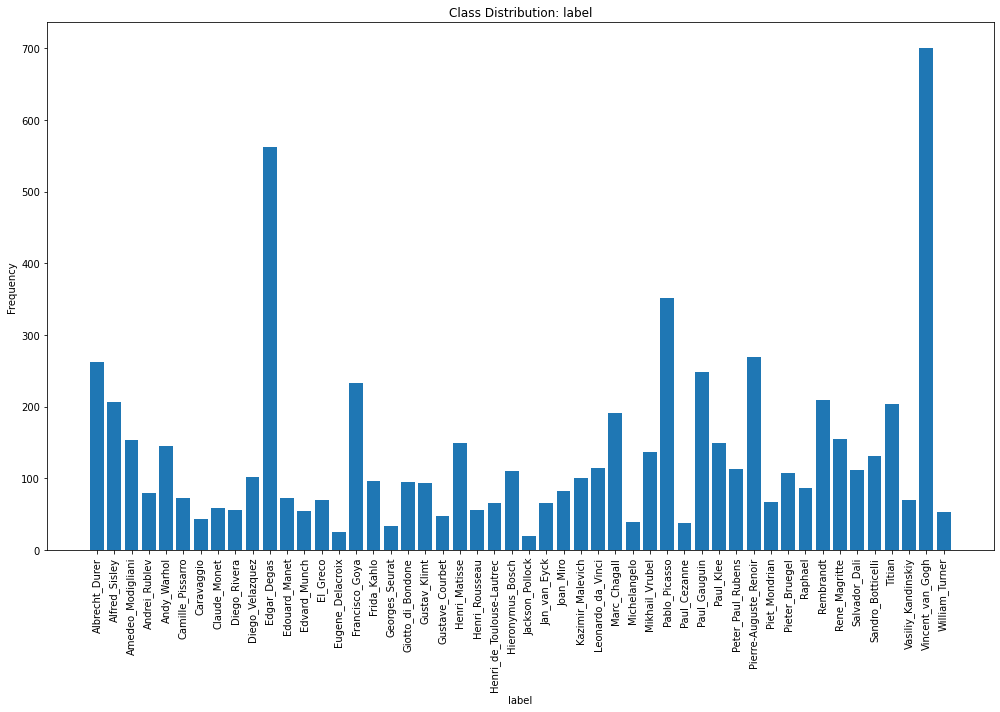


TEST SPLIT
Test samples: 1690
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 176
Min value: ['Jackson_Pollock']; 5


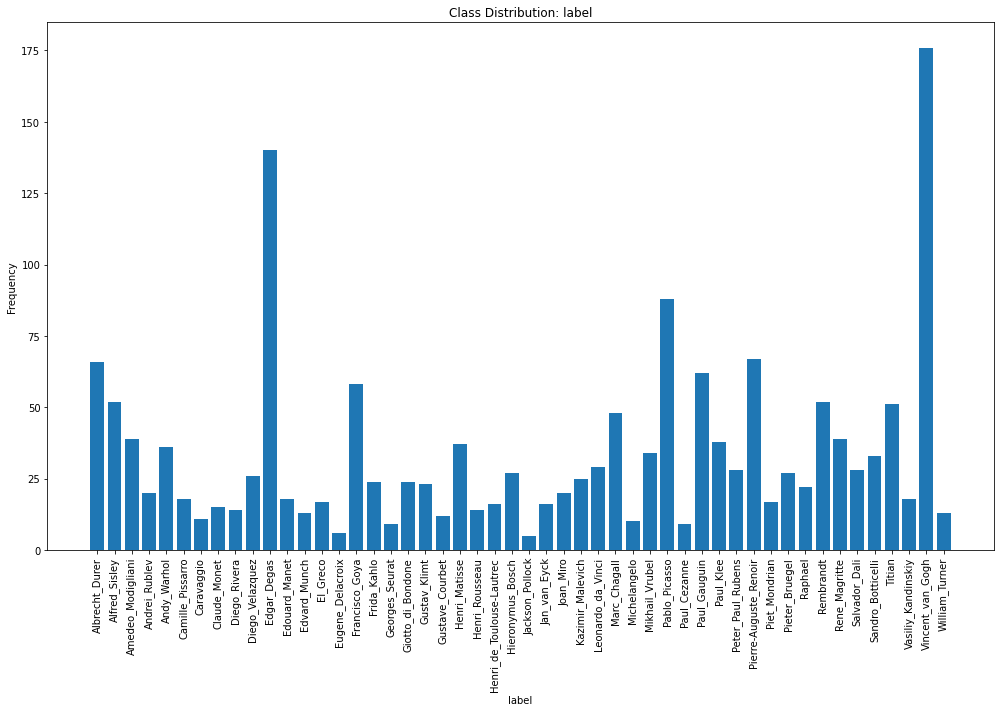

Train samples: 5404
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 561
Min value: ['Jackson_Pollock']; 15


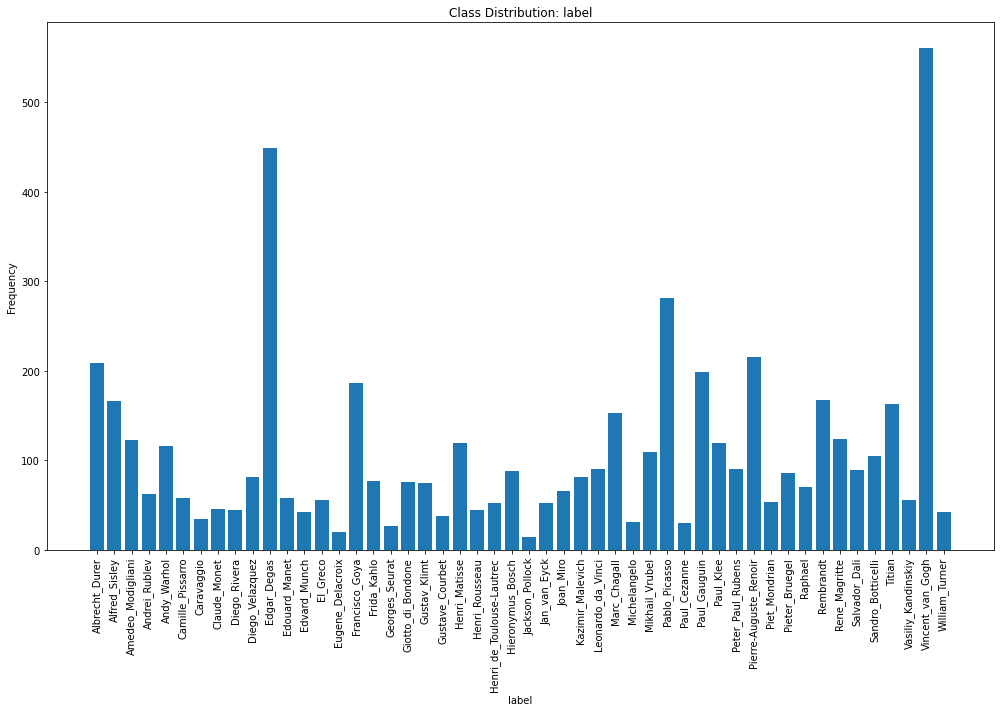

Validate samples: 1352
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 140
Min value: ['Jackson_Pollock']; 4


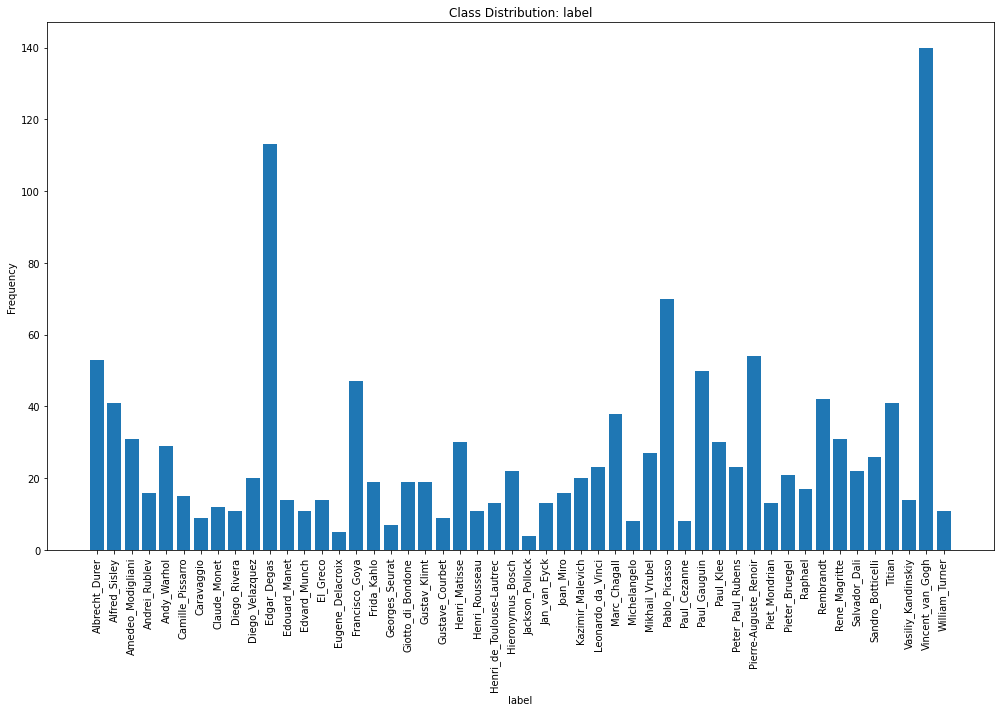


TRAIN / VALIDATE
Found 5404 validated image filenames belonging to 50 classes.
Found 1352 validated image filenames belonging to 50 classes.

TEST
Found 1690 validated image filenames belonging to 50 classes.
Total number of batches = 42 and 10


In [ ]:
df_all = pd.DataFrame.from_dict(painting_artist_dict, orient= 'index')
df_all.reset_index(level=0, inplace=True)
df_all.columns = ['filename', 'label']


# Split data in "train_validate" and "test" set in a stratified manner
X_train_val, X_test, y_train_val, y_test = train_test_split(
                                                    df_all['filename'],
                                                    df_all['label'],
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify= df_all['label']
                                                    )

print("TRAIN_VALIDATE SPLIT")
df_train_validate = pd.concat([X_train_val, y_train_val], axis=1)
print("Train_validate samples: %d" % df_train_validate.shape[0])
plot_class_distribution(df_train_validate, 'label')

print("")
print("TEST SPLIT")
df_test = pd.concat([X_test, y_test], axis=1)
print("Test samples: %d" % df_test.shape[0])
plot_class_distribution(df_test, 'label')



# Now stratified splitting the train and validate set
X_train, X_validate, y_train, y_validate = train_test_split(
                                                    df_train_validate['filename'],
                                                    df_train_validate['label'],
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify= df_train_validate['label']
                                                    )
df_train = pd.concat([X_train, y_train], axis=1)
print("Train samples: %d" % df_train.shape[0])
plot_class_distribution(df_train, 'label')

df_validate = pd.concat([X_validate, y_validate], axis=1)
print("Validate samples: %d" % df_validate.shape[0])
plot_class_distribution(df_validate, 'label')


print("")
print("TRAIN / VALIDATE")
# image data generator where augmentation can be used
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    subset= "training",
    x_col = 'filename',
    y_col = 'label',
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True,
    batch_size = batch_size
)


# no augmentation can be used here
validate_datagen = ImageDataGenerator()
valid_generator = validate_datagen.flow_from_dataframe(
    dataframe = df_validate,
    subset= "training",
    x_col = 'filename',
    y_col = 'label',
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True,
    batch_size = batch_size
)

print("")
print("TEST")
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'filename',
    y_col = 'label',
    target_size= train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

## 3. Model

In [ ]:
class HistoryCheckpoint(History):
  def __init__(self, pickle_path, monitor):
    """
    A custom callback that saves the training history to a pickle file after
    every epoch.
    Arguments:
      pickle_path: the path of where the history should be stored.
      monitor: the value that indicates what the 'best' model is.
    """
    super().__init__()
    self.pickle_path = pickle_path
    self.monitor = monitor
    self.is_resuming = False

  def load_history(self):
    """
    Try to open the history file at the given pickle_path.
    """
    with open(self.pickle_path, "rb") as file:
      self.history = pickle.load(file)
      self.epoch = [i for i in range(len(self.history['loss']))]
      self.is_resuming = True
      

  def on_train_begin(self, logs=None):
    # If not already resuming from a loaded history, then initialize all
    # fields using the code from the History callback.
    if not self.is_resuming:
      super().on_train_begin(logs)

  def on_epoch_end(self, epoch, logs=None):
    # Update the history according to the functionality of History.
    super().on_epoch_end(epoch, logs)

    # Save the history to a pickle file.
    with open(self.pickle_path, "wb") as file:
      pickle.dump(self.history, file)

  def on_train_end(self, logs=None):
    os.remove(self.pickle_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0

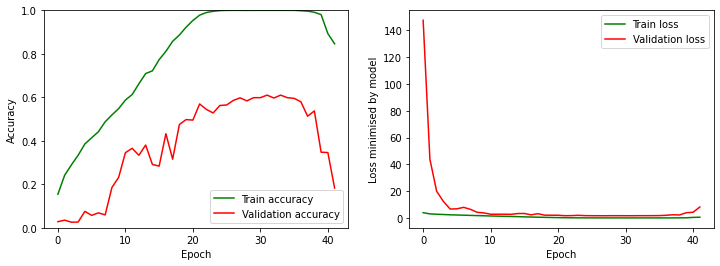

In [ ]:
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/"
best_model_savename = checkpoint_dir+"best_model.h5"
monitor = 'val_accuracy'

# CALLBACKS
best_cp_callback = ModelCheckpoint(best_model_savename,
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)

backup_callback = BackupAndRestore(checkpoint_dir + "backup/")

stopping_callback = EarlyStopping(monitor=monitor, patience=early_stopping_patience, verbose=1, 
                            mode='auto', restore_best_weights=True)

history_callback = HistoryCheckpoint(checkpoint_dir + "history.pi", 
                                     monitor=monitor)



# CREATE MODEL
# model = example_model()
model = initial_model()
model.summary()

# START TRAINING
try:
  # Try to resume from a history.
  history_callback.load_history()

  # Set the best value from this history in the 'best model' callback.
  if best_cp_callback.monitor_op == np.less:
    best_cp_callback.best = np.min(history_callback.history[monitor])
  if best_cp_callback.monitor_op == np.greater:
    best_cp_callback.best = np.max(history_callback.history[monitor])
  print(f"History with {len(history_callback.epoch)} epochs loaded!")
except OSError:
  print("No history found, starting new logs!")


callbacks = [history_callback, backup_callback, best_cp_callback]
if early_stopping_patience != 0:
  callbacks.append(stopping_callback)



model.fit(train_generator, steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data=valid_generator, validation_steps = STEP_SIZE_VALID,
          epochs=n_epoch,
          shuffle=True,
          verbose=2,
          callbacks=callbacks
          )
history = history_callback

[train_loss, train_accuracy] = model.evaluate(train_generator, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(valid_generator, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))



plot_history(history)

In [ ]:
# Normally, the backup is deleted automatically after all training epochs have ended. 
# Executing this command forces the deletion even if the training is not done yet.
!rm -r "{checkpoint_dir + "backup/"}"
#!rm -r "{checkpoint_dir + "checkpoints/"}"

# Again, the history will be removed after a full training run automatically,
# but you can force the history to be deleted to be sure:
!rm -r "{checkpoint_dir + "history.pi"}"

rm: cannot remove '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/history.pi': No such file or directory


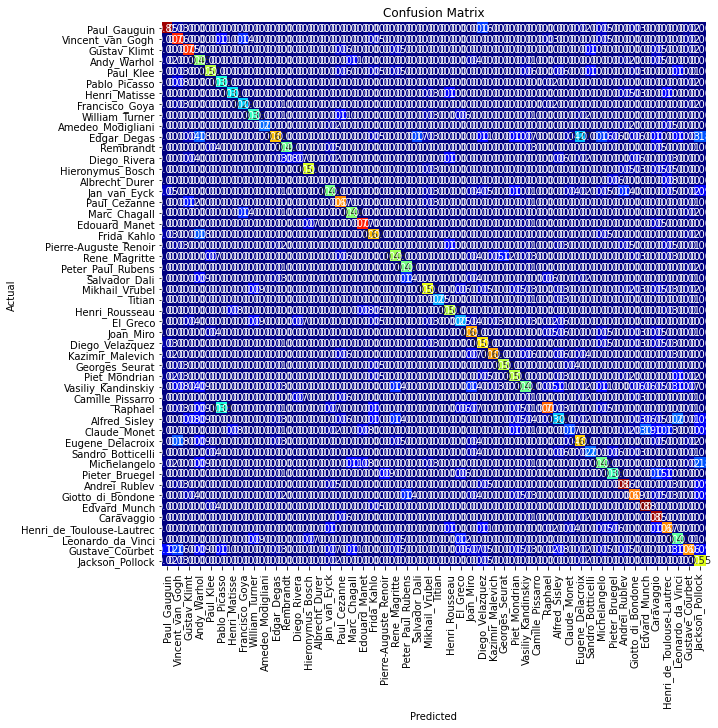

Classification Report:
                           precision    recall  f1-score   support

             Paul_Gauguin       0.73      0.85      0.78        60
         Vincent_van_Gogh       0.51      0.76      0.61        38
             Gustav_Klimt       0.64      0.75      0.69        24
              Andy_Warhol       0.31      0.45      0.37        11
                Paul_Klee       0.70      0.50      0.58        28
            Pablo_Picasso       0.38      0.33      0.35         9
            Henri_Matisse       0.67      0.31      0.42        13
           Francisco_Goya       0.50      0.29      0.36         7
           William_Turner       0.57      0.36      0.44        11
        Amedeo_Modigliani       1.00      0.20      0.33         5
              Edgar_Degas       0.69      0.62      0.65       117
                Rembrandt       0.83      0.42      0.56        12
             Diego_Rivera       0.33      0.07      0.12        14
         Hieronymus_Bosch       0.80  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

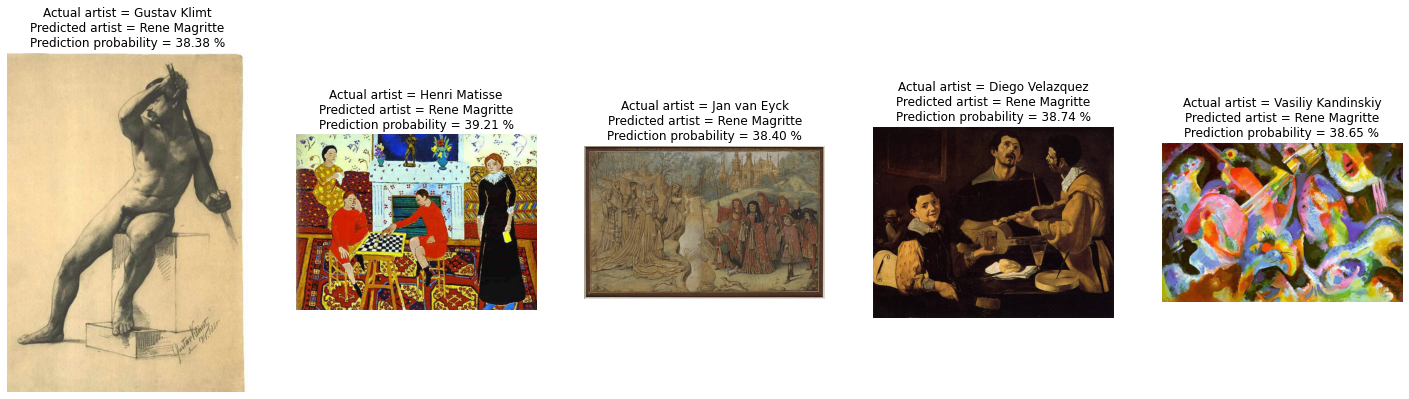

In [ ]:
# Prediction
from keras.preprocessing import *
from PIL import Image

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(list(artist_painting_dict.keys()))
    random_image_file = random.choice(artist_painting_dict[random_artist])

    test_image = Image.open(random_image_file) 
    test_image = test_image.resize(train_input_shape[0:2])

    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [ ]:
[test_loss, test_accuracy] = model.evaluate(test_generator, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))

Test set Accuracy:   0.60
Test set Loss: 1.6592

